In [1]:
import pandas as pd
import os
import ast
import re

In [2]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [3]:
ai_decision = pd.read_csv("results/ai_decision.csv")
print("# of selected articles = ", ai_decision.decision.sum())

# of selected articles =  21


In [4]:
OUT_DIR = "results"
COLUMNS = ["key", "title", "authors", "journal", "year", "abstract", "keywords", "notes"]

raw = pd.read_csv(os.path.join("../dataset/screening/articles_final_072025.csv"))[COLUMNS]

human_decision = {}

for i, row in raw.iterrows():

    row_dict = row.to_dict()

    review_notes = row_dict["notes"]
    review_dict = ast.literal_eval(re.findall(r"\{.*?\}", review_notes)[0].replace("=>",":"))
    
    decision = 0 if review_dict["Giulia"]=="Excluded" else 1

    
    for key,value in row_dict.items():
       human_decision.setdefault(key,[]).append(value)

    human_decision.setdefault("human_decision", []).append(decision)
   
human_decision = pd.DataFrame(human_decision)

In [5]:
human_decision = human_decision.sort_values(by="key").reset_index(drop=True)
ai_decision = ai_decision.sort_values(by="key").reset_index(drop=True).rename(columns={"decision": "ai_decision", "reason":"ai_reason"})

merged_decision = human_decision.copy()

for key in ["ai_decision", "ai_method_list", "ai_reason"]:
    merged_decision[key] = ai_decision[key]

merged_decision = merged_decision.map(lambda x:'[]' if pd.isna(x) else x)

In [9]:
len(merged_decision[(merged_decision.human_decision==1)&(merged_decision.ai_decision==1)])

14

### WordCloud where AI reviewer's decision matched v/s mismatched with human 

In [9]:
from collections import Counter

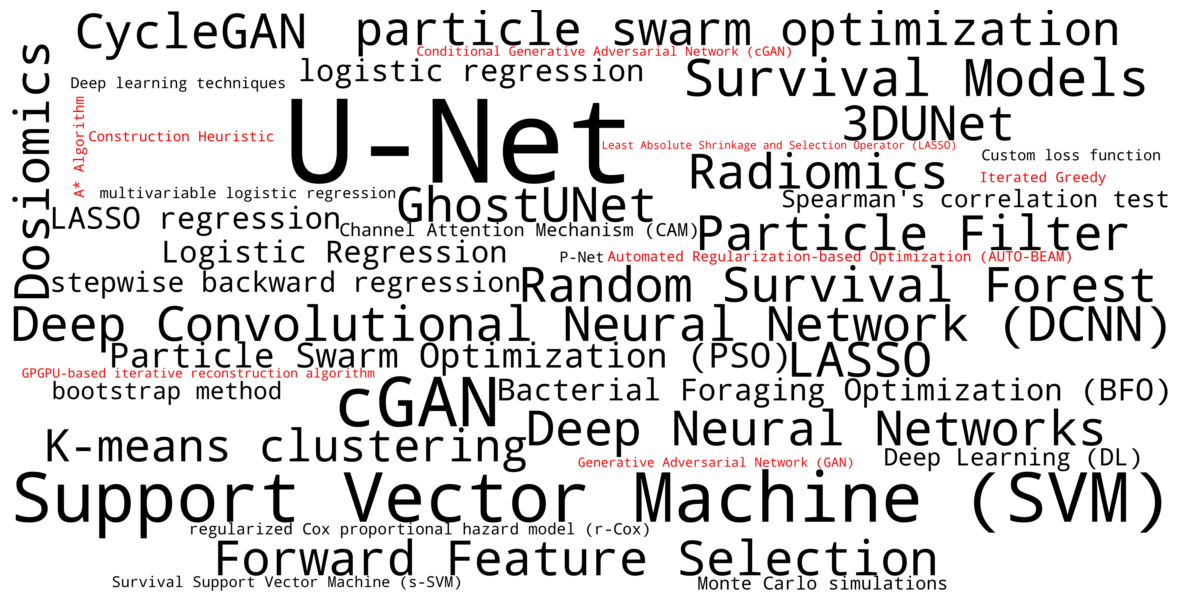

In [56]:
df = merged_decision[(merged_decision.ai_decision==merged_decision.human_decision)]
list_of_lists = [ast.literal_eval(item) for item in df.ai_method_list.to_list()]
words_agreed = sum(list_of_lists,[])

df = merged_decision[(merged_decision.ai_decision!=merged_decision.human_decision)]
list_of_lists = [ast.literal_eval(item) for item in df.ai_method_list.to_list()]
words_disagreed = sum(list_of_lists,[])
words_disagreed.remove('Not explicitly listed in the abstract.')

freq_dict = Counter(words_agreed) + Counter(words_disagreed)

# Custom color function
def color_func(word, *args, **kwargs):
    if word in words_agreed:
        return "black"
    elif word in words_disagreed:
        return "red"
    else:
        return "gray"   # fallback

# Generate one word cloud
wordcloud = WordCloud(
    width=8000, height=4000, background_color='white', random_state=42,
    color_func=color_func
).generate_from_frequencies(freq_dict)

# Plot
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('results/ai_methods_screening.png', dpi=900, bbox_inches='tight')
plt.show()


## AI Methods Yearly Trend of Selected Articles

/tmp/ipykernel_3338315/2444170613.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


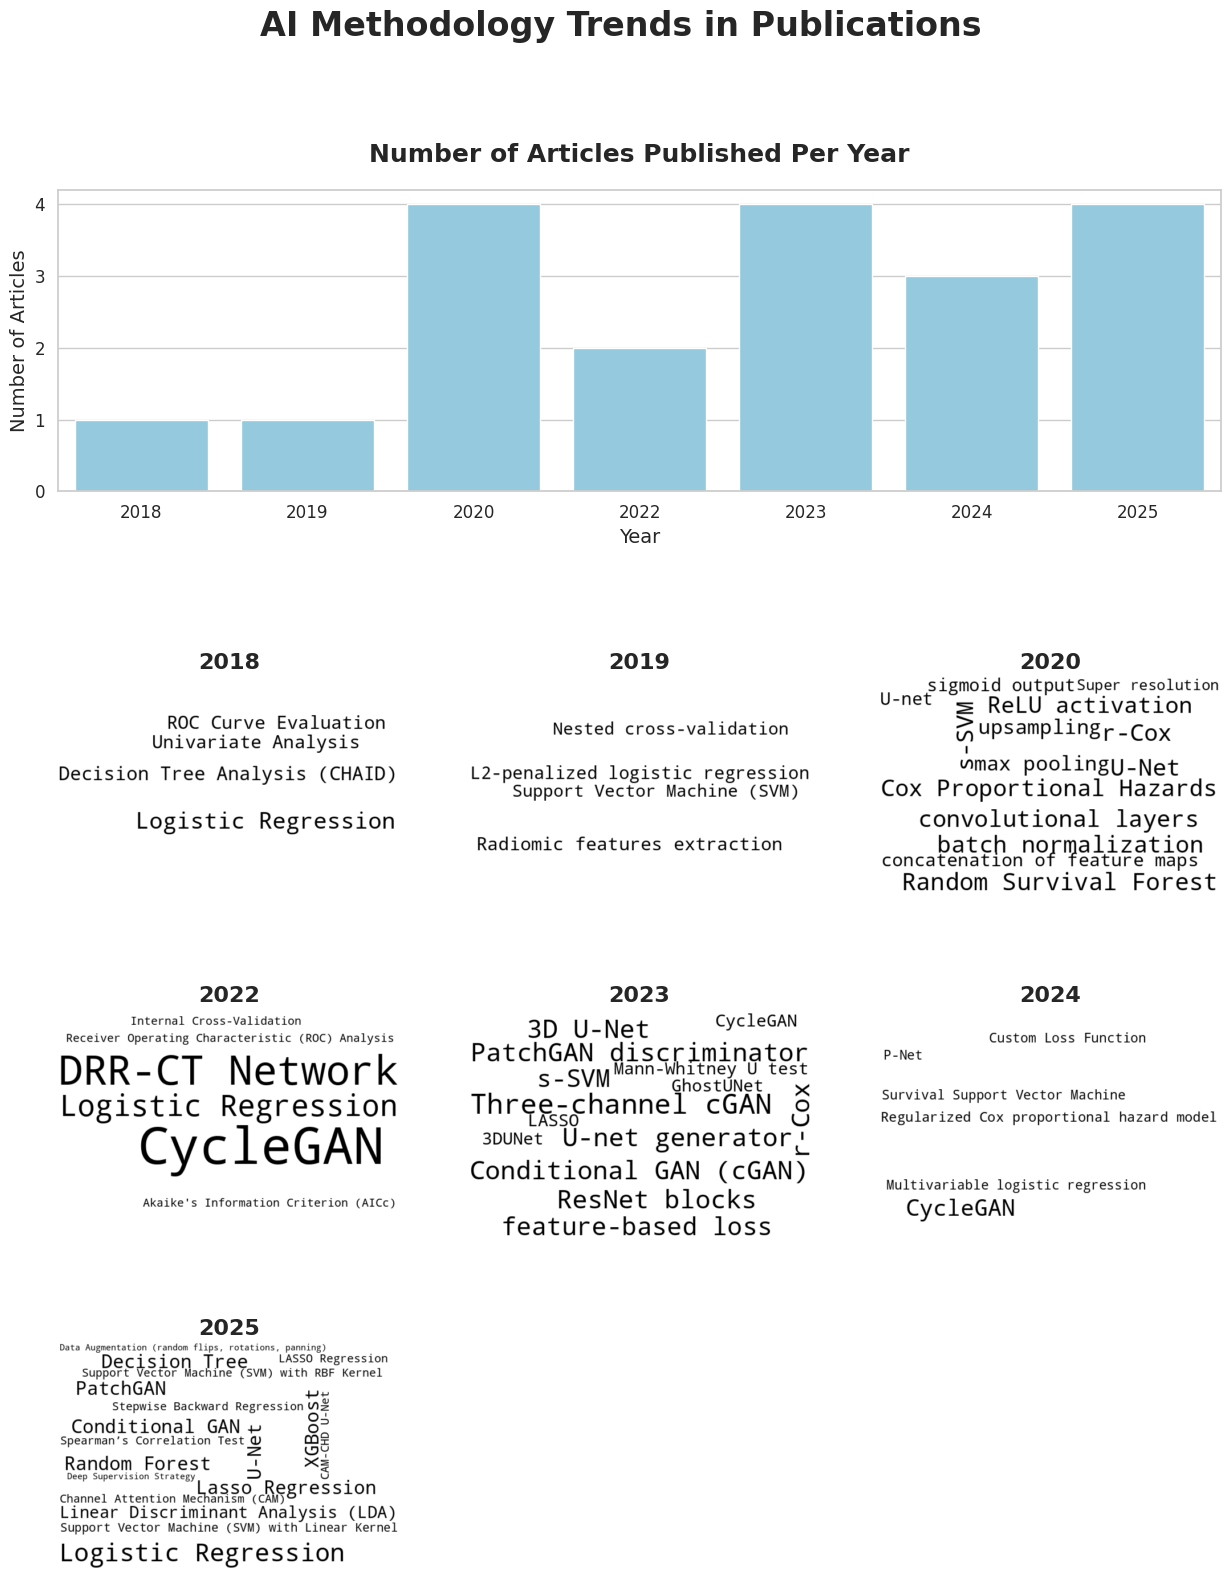

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from wordcloud import WordCloud
import seaborn as sns
import re
import math

# --- User Configuration ---
CSV_FILE_PATH = 'results/ai_review.csv'
# Add more stop words to this set to exclude them from the word cloud
STOP_WORDS = set(['the', 'and', 'to', 'of', 'a', 'in', 'for', 'with', 'is', 'on', 'an', 'by', 'as', 's', 'are', 'from', 'we', 'that', 'it', 'were', 'was', 'have', 'been', 'this', 'at', 'can', 'be', 'used', 'using', 'based', 'model', 'data', 'method'])

def generate_vertical_wordcloud_plot(file_path):
    """
    Reads a CSV and generates a top-and-bottom plot with publication trends
    and yearly AI methodology word clouds.
    """
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        print("Please ensure the CSV file is in the same directory or provide the full path.")
        return

    # --- Data Preparation ---
    df['Year of pubblication'] = pd.to_numeric(df['Year of pubblication'], errors='coerce').dropna()
    df['Year of pubblication'] = df['Year of pubblication'].astype(int)
    yearly_counts = df['Year of pubblication'].value_counts().sort_index()
    years = sorted(df['Year of pubblication'].unique())

    # --- Plotting Setup ---
    sns.set(style="whitegrid", font_scale=1.1)
    fig = plt.figure(figsize=(15, 18))
    # Create a GridSpec layout: 2 main rows. Top is for the bar chart, bottom for word clouds.
    gs_main = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[1, 3], hspace=0.3)

    # --- Top Panel: Number of Articles per Year ---
    ax_top = fig.add_subplot(gs_main[0])
    sns.barplot(x=yearly_counts.index, y=yearly_counts.values, ax=ax_top, color='skyblue')
    ax_top.set_title('Number of Articles Published Per Year', fontsize=18, weight='bold', pad=20)
    ax_top.set_xlabel('Year', fontsize=14)
    ax_top.set_ylabel('Number of Articles', fontsize=14)
    ax_top.tick_params(axis='x', rotation=0)

    # --- Bottom Panel: Yearly Word Clouds ---
    # Create a nested GridSpec for the word clouds
    cols = 3 # Number of columns for word clouds
    rows = math.ceil(len(years) / cols)
    gs_bottom = gridspec.GridSpecFromSubplotSpec(rows, cols, subplot_spec=gs_main[1], hspace=0.4, wspace=0.2)

    for i, year in enumerate(years):
        ax = fig.add_subplot(gs_bottom[i])
        year_df = df[df['Year of pubblication'] == year]
        words = sum(year_df.ai_method_list.dropna().apply(eval).to_list(),[])
        freq_dict = Counter(words)

        if freq_dict:
            wordcloud = WordCloud(
                width=600,
                height=400,
                background_color="white",
                color_func=lambda *args, **kwargs: "black", random_state=0
            ).generate_from_frequencies(freq_dict)

            # wordcloud = WordCloud(
            #     width=600,
            #     height=400,
            #     background_color="white",
            #     color_func=lambda *args, **kwargs: "black", random_state=0
            # ).generate(" ".join(words))
          
            ax.imshow(wordcloud, interpolation='bilinear')
            ax.set_title(str(year), fontsize=16, weight='bold')
        else:
            ax.text(0.5, 0.5, 'No Data', ha='center', va='center', fontsize=12)
            ax.set_title(str(year), fontsize=16, weight='bold')

        ax.axis('off')

    # Hide any unused subplots in the bottom grid
    for i in range(len(years), rows * cols):
        fig.add_subplot(gs_bottom[i]).axis('off')

    fig.suptitle('AI Methodology Trends in Publications', fontsize=24, weight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig('vertical_wordcloud_plot.png', dpi=300)
    plt.show()

if __name__ == '__main__':
    generate_vertical_wordcloud_plot(CSV_FILE_PATH)

/tmp/ipykernel_3668256/3371550337.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


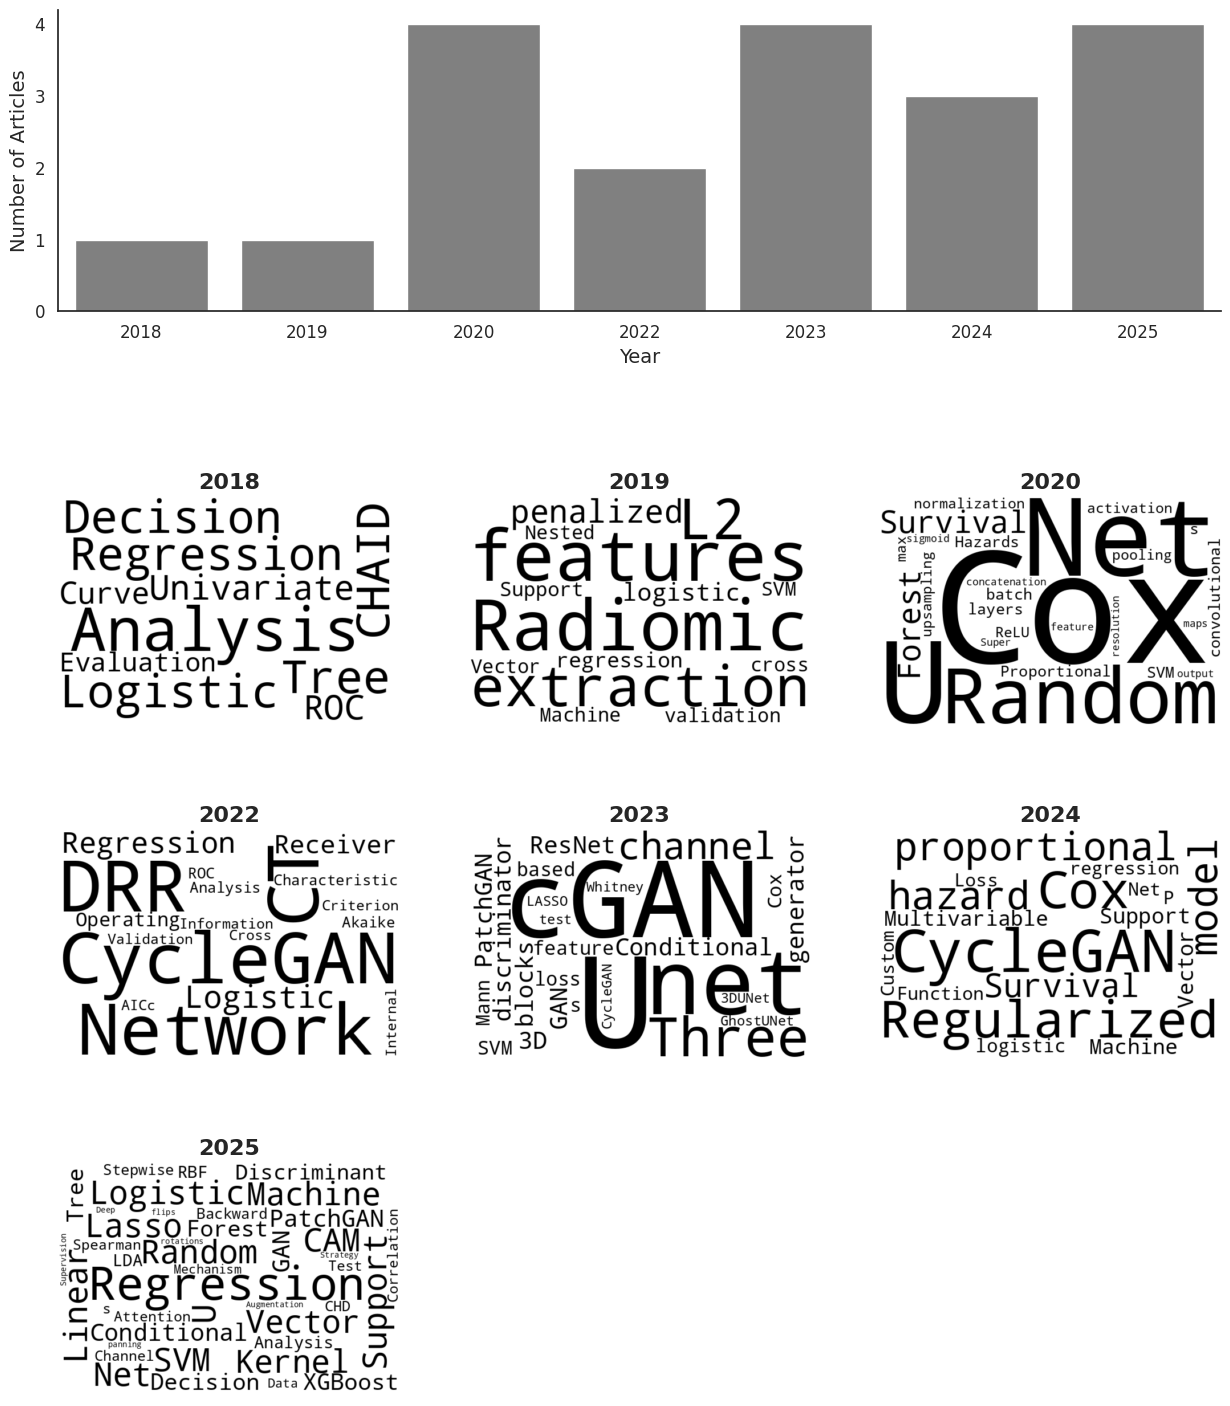

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from wordcloud import WordCloud
import seaborn as sns
import re
import math

# --- User Configuration ---
CSV_FILE_PATH = 'results/ai_review.csv'
# Add more stop words to this set to exclude them from the word cloud
STOP_WORDS = set(['the', 'and', 'to', 'of', 'a', 'in', 'for', 'with', 'is', 'on', 'an', 'by', 'as', 's', 'are', 'from', 'we', 'that', 'it', 'were', 'was', 'have', 'been', 'this', 'at', 'can', 'be', 'used', 'using', 'based', 'model', 'data', 'method'])

def generate_vertical_wordcloud_plot(file_path):
    """
    Reads a CSV and generates a top-and-bottom plot with publication trends
    and yearly AI methodology word clouds.
    """
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        print("Please ensure the CSV file is in the same directory or provide the full path.")
        return

    # --- Data Preparation ---
    df['Year of pubblication'] = pd.to_numeric(df['Year of pubblication'], errors='coerce').dropna()
    df['Year of pubblication'] = df['Year of pubblication'].astype(int)
    yearly_counts = df['Year of pubblication'].value_counts().sort_index()
    years = sorted(df['Year of pubblication'].unique())

    # --- Plotting Setup ---
    sns.set(style="white", font_scale=1.1)
    fig = plt.figure(figsize=(15, 18))
    # Create a GridSpec layout: 2 main rows. Top is for the bar chart, bottom for word clouds.
    gs_main = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[1, 3], hspace=0.3)

    # --- Top Panel: Number of Articles per Year ---
    ax_top = fig.add_subplot(gs_main[0])
    sns.barplot(x=yearly_counts.index, y=yearly_counts.values, ax=ax_top, color='gray')
    # ax_top.set_title('Number of Articles Published Per Year', fontsize=18, weight='bold', pad=20)
    ax_top.set_xlabel('Year', fontsize=14)
    ax_top.set_ylabel('Number of Articles', fontsize=14)
    ax_top.tick_params(axis='x', rotation=0)
    ax_top.spines['top'].set_visible(False)
    ax_top.spines['right'].set_visible(False)

    # --- Bottom Panel: Yearly Word Clouds ---
    # Create a nested GridSpec for the word clouds
    cols = 3 # Number of columns for word clouds
    rows = math.ceil(len(years) / cols)
    gs_bottom = gridspec.GridSpecFromSubplotSpec(rows, cols, subplot_spec=gs_main[1], hspace=0.4, wspace=0.2)

    for i, year in enumerate(years):
        ax = fig.add_subplot(gs_bottom[i])
        year_df = df[df['Year of pubblication'] == year]
        words = sum(year_df.ai_method_list.dropna().apply(eval).to_list(),[])
        freq_dict = Counter(words)

        if freq_dict:
            # wordcloud = WordCloud(
            #     width=600,
            #     height=400,
            #     background_color="white",
            #     color_func=lambda *args, **kwargs: "black", random_state=0
            # ).generate_from_frequencies(freq_dict)

            wordcloud = WordCloud(
                width=600,
                height=400,
                background_color="white",
                color_func=lambda *args, **kwargs: "black", random_state=0
            ).generate(" ".join(words))
            # wordcloud = WordCloud(
            #     width=400, height=200, background_color='white',
            #     stopwords=STOP_WORDS, colormap='cividis', max_words=40
            # ).generate(text)
            ax.imshow(wordcloud, interpolation='bilinear')
            ax.set_title(str(year), fontsize=16, weight='bold')
        else:
            ax.text(0.5, 0.5, 'No Data', ha='center', va='center', fontsize=12)
            ax.set_title(str(year), fontsize=16, weight='bold')

        ax.axis('off')
       

    # Hide any unused subplots in the bottom grid
    for i in range(len(years), rows * cols):
        fig.add_subplot(gs_bottom[i]).axis('off')

    # fig.suptitle('AI Methodology Trends in Publications', fontsize=24, weight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
   
    
    plt.savefig('vertical_wordcloud_plot.png', dpi=300)
    plt.show()

if __name__ == '__main__':
    generate_vertical_wordcloud_plot(CSV_FILE_PATH)

/tmp/ipykernel_3668256/2611106005.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


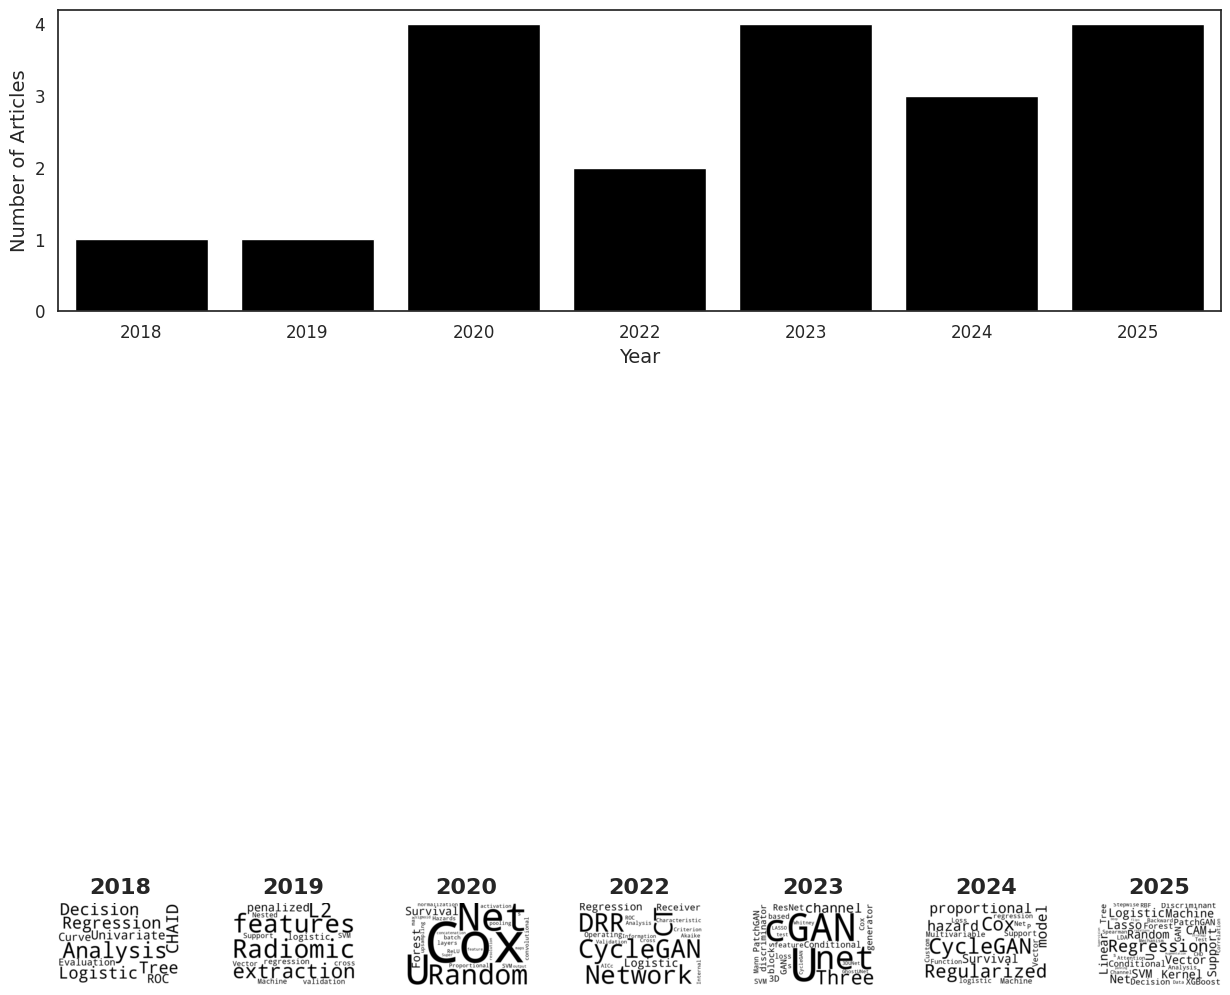

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from wordcloud import WordCloud
import seaborn as sns
import re
import math

# --- User Configuration ---
CSV_FILE_PATH = 'results/ai_review.csv'
# Add more stop words to this set to exclude them from the word cloud
STOP_WORDS = set(['the', 'and', 'to', 'of', 'a', 'in', 'for', 'with', 'is', 'on', 'an', 'by', 'as', 's', 'are', 'from', 'we', 'that', 'it', 'were', 'was', 'have', 'been', 'this', 'at', 'can', 'be', 'used', 'using', 'based', 'model', 'data', 'method'])

def generate_vertical_wordcloud_plot(file_path):
    """
    Reads a CSV and generates a top-and-bottom plot with publication trends
    and yearly AI methodology word clouds.
    """
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        print("Please ensure the CSV file is in the same directory or provide the full path.")
        return

    # --- Data Preparation ---
    df['Year of pubblication'] = pd.to_numeric(df['Year of pubblication'], errors='coerce').dropna()
    df['Year of pubblication'] = df['Year of pubblication'].astype(int)
    yearly_counts = df['Year of pubblication'].value_counts().sort_index()
    years = sorted(df['Year of pubblication'].unique())

    # --- Plotting Setup ---
    sns.set(style="white", font_scale=1.1)
    fig = plt.figure(figsize=(15, 18))
    # Create a GridSpec layout: 2 main rows. Top is for the bar chart, bottom for word clouds.
    gs_main = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[1, 3], hspace=0.3)

    # --- Top Panel: Number of Articles per Year ---
    ax_top = fig.add_subplot(gs_main[0])
    sns.barplot(x=yearly_counts.index, y=yearly_counts.values, ax=ax_top, color='black')
    # ax_top.set_title('Number of Articles Published Per Year', fontsize=18, weight='bold', pad=20)
    ax_top.set_xlabel('Year', fontsize=14)
    ax_top.set_ylabel('Number of Articles', fontsize=14)
    ax_top.tick_params(axis='x', rotation=0)

    # --- Bottom Panel: Yearly Word Clouds ---
    # Create a nested GridSpec for the word clouds
    cols = len(years) # Number of columns for word clouds
    rows = 1
    gs_bottom = gridspec.GridSpecFromSubplotSpec(
    rows, cols, subplot_spec=gs_main[1], wspace=0.4
    )

    for i, year in enumerate(years):
        ax = fig.add_subplot(gs_bottom[i])
        year_df = df[df['Year of pubblication'] == year]
        words = sum(year_df.ai_method_list.dropna().apply(eval).to_list(),[])
        freq_dict = Counter(words)

        if freq_dict:
            # wordcloud = WordCloud(
            #     width=600,
            #     height=400,
            #     background_color="white",
            #     color_func=lambda *args, **kwargs: "black", random_state=0
            # ).generate_from_frequencies(freq_dict)

            wordcloud = WordCloud(
                width=600,
                height=400,
                background_color="white",
                color_func=lambda *args, **kwargs: "black", random_state=0
            ).generate(" ".join(words))
            # wordcloud = WordCloud(
            #     width=400, height=200, background_color='white',
            #     stopwords=STOP_WORDS, colormap='cividis', max_words=40
            # ).generate(text)
            ax.imshow(wordcloud, interpolation='bilinear')
            ax.set_title(str(year), fontsize=16, weight='bold')
        else:
            ax.text(0.5, 0.5, 'No Data', ha='center', va='center', fontsize=12)
            ax.set_title(str(year), fontsize=16, weight='bold')

        ax.axis('off')

    # Hide any unused subplots in the bottom grid
    for i in range(len(years), rows * cols):
        fig.add_subplot(gs_bottom[i]).axis('off')

    # fig.suptitle('AI Methodology Trends in Publications', fontsize=24, weight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig('results/trend.png', dpi=900)
    plt.show()

if __name__ == '__main__':
    generate_vertical_wordcloud_plot(CSV_FILE_PATH)

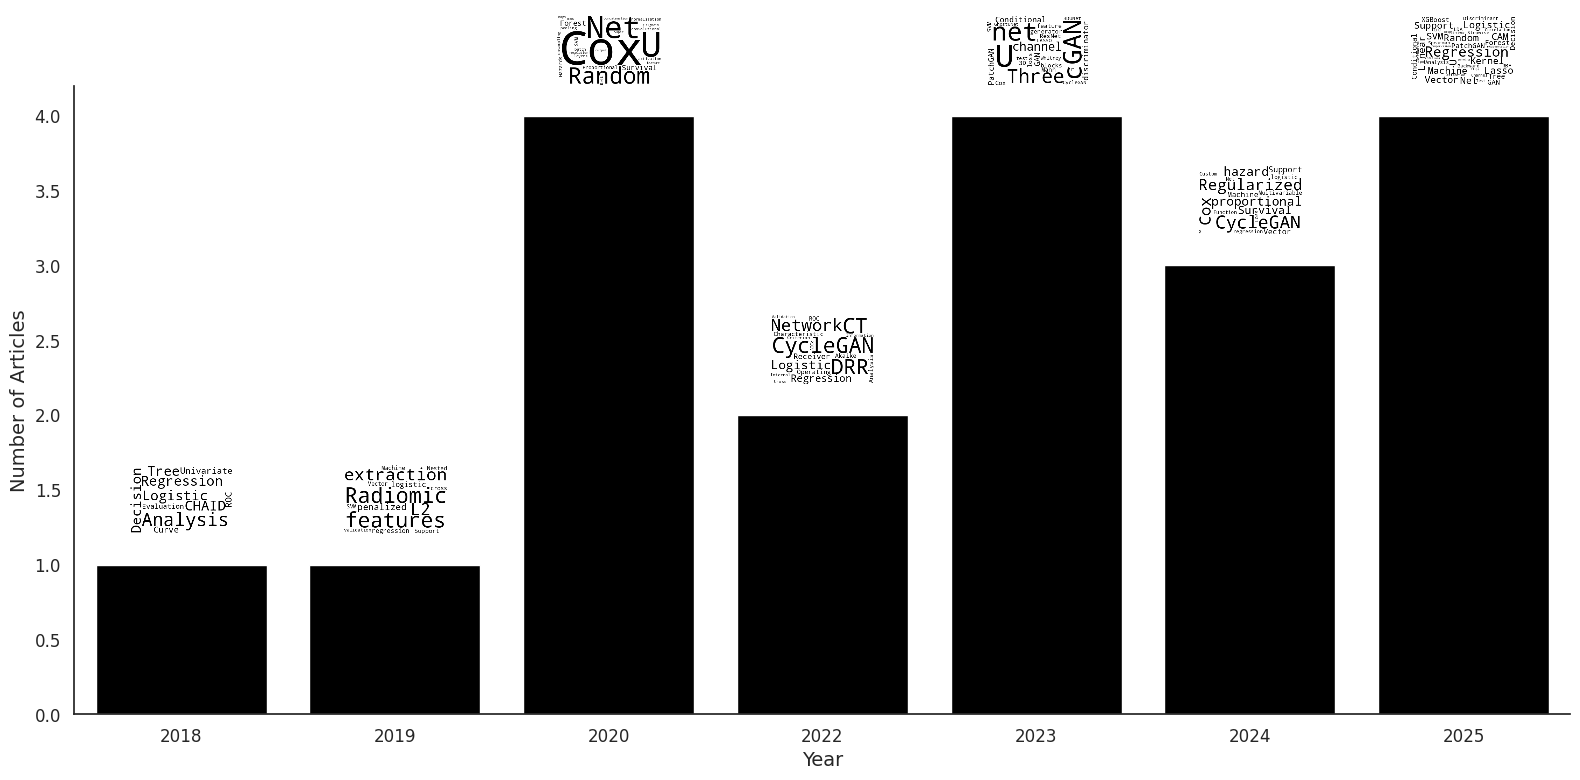

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from wordcloud import WordCloud
import seaborn as sns
from collections import Counter

# --- User Configuration ---
CSV_FILE_PATH = 'results/ai_review.csv'
STOP_WORDS = set([
    'the', 'and', 'to', 'of', 'a', 'in', 'for', 'with', 'is', 'on', 'an', 'by', 'as', 's', 'are', 'from',
    'we', 'that', 'it', 'were', 'was', 'have', 'been', 'this', 'at', 'can', 'be', 'used', 'using',
    'based', 'model', 'data', 'method'
])

def generate_wordcloud_barplot(file_path):
    """
    Plots the number of articles per year with a small word cloud above each bar.
    """
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return

    # --- Data Preparation ---
    df['Year of pubblication'] = pd.to_numeric(df['Year of pubblication'], errors='coerce')
    df = df.dropna(subset=['Year of pubblication'])
    df['Year of pubblication'] = df['Year of pubblication'].astype(int)

    yearly_counts = df['Year of pubblication'].value_counts().sort_index()
    years = sorted(df['Year of pubblication'].unique())

    # --- Plot Setup ---
    sns.set(style="white", font_scale=1.1)
    fig, ax = plt.subplots(figsize=(16, 8))
    sns.barplot(x=yearly_counts.index, y=yearly_counts.values, ax=ax, color='black')
    ax.grid(False)

    # ax.set_title('AI Methodology Trends in Publications', fontsize=20, weight='bold', pad=20)
    ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel('Number of Articles', fontsize=14)

    # --- Generate and Place Word Clouds Above Bars ---
    for i, year in enumerate(years):
        year_df = df[df['Year of pubblication'] == year]

        try:
            words = sum(year_df.ai_method_list.dropna().apply(eval).to_list(), [])
        except Exception:
            words = []

        if not words:
            continue

        freq_dict = Counter(words)
        wordcloud = WordCloud(
            width=300,
            height=200,
            background_color="white",
            color_func=lambda *args, **kwargs: "black",
            stopwords=STOP_WORDS,
            random_state=0
        ).generate(" ".join(words))

        # Convert word cloud to image array
        img = wordcloud.to_array()
        imagebox = OffsetImage(img, zoom=0.25)
        ab = AnnotationBbox(
            imagebox,
            (i, yearly_counts.iloc[i] + max(yearly_counts) * 0.05),  # position above bar
            frameon=False,
            box_alignment=(0.5, 0)
        )
        ax.add_artist(ab)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig('wordcloud_barplot.png', dpi=300)
    plt.show()

if __name__ == '__main__':
    generate_wordcloud_barplot(CSV_FILE_PATH)


In [37]:
# --- Generate and Place Word Clouds Above Bars ---
max_count = yearly_counts.max()

for i, year in enumerate(years):
    year_df = df[df['Year of pubblication'] == year]

    try:
        words = sum(year_df.ai_method_list.dropna().apply(eval).to_list(), [])
    except Exception:
        words = []

    if not words:
        continue

    freq_dict = Counter(words)
    wordcloud = WordCloud(
        width=300,
        height=200,
        background_color="white",
        color_func=lambda *args, **kwargs: "black",
        stopwords=STOP_WORDS,
        random_state=0
    ).generate(" ".join(words))

    # Scale zoom relative to the bar height
    bar_height = yearly_counts.iloc[i]
    zoom_factor = 0.2 + 0.5 * (bar_height / max_count)  # adjust 0.2 and 0.5 for min/max zoom
    img = wordcloud.to_array()
    imagebox = OffsetImage(img, zoom=zoom_factor)

    ab = AnnotationBbox(
        imagebox,
        (i, bar_height + max_count * 0.05),  # position above bar
        frameon=False,
        box_alignment=(0.5, 0)
    )
    ax.add_artist(ab)


NameError: name 'yearly_counts' is not defined

In [51]:
87/60

1.45

In [54]:
["paz"+str(i) for i in np.arange(1,42)]

['paz1',
 'paz2',
 'paz3',
 'paz4',
 'paz5',
 'paz6',
 'paz7',
 'paz8',
 'paz9',
 'paz10',
 'paz11',
 'paz12',
 'paz13',
 'paz14',
 'paz15',
 'paz16',
 'paz17',
 'paz18',
 'paz19',
 'paz20',
 'paz21',
 'paz22',
 'paz23',
 'paz24',
 'paz25',
 'paz26',
 'paz27',
 'paz28',
 'paz29',
 'paz30',
 'paz31',
 'paz32',
 'paz33',
 'paz34',
 'paz35',
 'paz36',
 'paz37',
 'paz38',
 'paz39',
 'paz40',
 'paz41']

In [61]:
1051/60

17.516666666666666

In [75]:
np.array([(pid, timeArray[pid].max().item()) for pid in set(["paz"+str(i) for i in np.arange(42,59)]).intersection(timeArray.keys())])

array([['paz42', '87.921875'],
       ['paz55', '1051.8125'],
       ['paz56', '953.71875'],
       ['paz45', '47.921875'],
       ['paz54', '913.703125'],
       ['paz53', '953.71875'],
       ['paz58', '4953.703125'],
       ['paz46', '913.703125'],
       ['paz57', '913.703125'],
       ['paz50', '953.703125'],
       ['paz52', '913.703125'],
       ['paz48', '953.703125'],
       ['paz44', '87.9296875'],
       ['paz43', '87.921875']], dtype='<U32')

In [77]:
953/60

15.883333333333333

In [76]:
timeArray['paz58']

array([   0.      ,   48.921875,   55.40625 ,   61.890625,   68.390625,
         74.875   ,   81.359375,   87.84375 ,   94.328125,  100.8125  ,
        147.29688 ,  153.78125 ,  160.26562 ,  166.75    ,  173.23438 ,
        179.71875 ,  186.20312 ,  192.70312 ,  199.1875  ,  245.67188 ,
        252.15625 ,  258.64062 ,  265.125   ,  271.60938 ,  278.09375 ,
        284.57812 ,  291.0625  ,  297.54688 ,  344.03125 ,  350.51562 ,
        357.      ,  363.48438 ,  369.98438 ,  376.46875 ,  382.95312 ,
        389.4375  ,  395.92188 ,  402.40625 ,  448.89062 ,  455.375   ,
        461.85938 ,  468.34375 ,  474.82812 ,  481.3125  ,  487.79688 ,
        494.28125 ,  500.76562 ,  547.2656  ,  553.75    ,  560.2344  ,
        566.71875 ,  573.2031  ,  579.6875  ,  586.1719  ,  592.65625 ,
        599.1406  ,  645.625   ,  652.1094  ,  658.59375 ,  665.0781  ,
        671.5781  ,  678.0625  ,  684.5469  ,  691.03125 ,  697.5156  ,
       4744.      , 4750.4844  , 4756.9688  , 4763.453   , 4769.

In [70]:
4953/60

82.55

In [71]:
set(["paz"+str(i) for i in np.arange(42,59)]).intersection(timeArray.keys())

{'paz42',
 'paz43',
 'paz44',
 'paz45',
 'paz46',
 'paz48',
 'paz50',
 'paz52',
 'paz53',
 'paz54',
 'paz55',
 'paz56',
 'paz57',
 'paz58'}

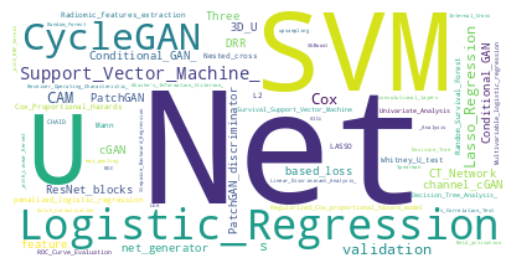

In [23]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Your list of phrases
# words = ['hi there', 'hello', 'hi there', 'hello', 'hello']

# Replace spaces with underscores to keep phrases together
processed_words = [w.replace(" ", "_") for w in words]

# Join into one big string (wordcloud expects a string)
text = " ".join(processed_words)

# Generate word cloud
wc = WordCloud(background_color="white").generate(text)

# Display
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()


In [ ]:
OUT_DIR = "results"
COLUMNS = ["key", "title", "authors", "journal", "year", "abstract", "keywords", "notes"]

raw = pd.read_csv(os.path.join("..","dataset/screening/articles_final_072025.csv"))[COLUMNS]
ai_decision = pd.read_csv(os.path.join("results/ai_decision.csv"))

In [162]:
human_decision = {}

for i, row in raw.iterrows():

    row_dict = row.to_dict()

    review_notes = row_dict["notes"]
    review_dict = ast.literal_eval(re.findall(r"\{.*?\}", review_notes)[0].replace("=>",":"))
    
    decision = 0 if review_dict["Giulia"]=="Excluded" else 1

    
    for key,value in row_dict.items():
       human_decision.setdefault(key,[]).append(value)

    human_decision.setdefault("human_decision", []).append(decision)
   
human_decision = pd.DataFrame(human_decision)
human_decision.to_csv(os.path.join("results", "human_decision.csv"), index=False)

In [163]:
human_decision = human_decision.sort_values(by="key").reset_index(drop=True)
ai_decision = ai_decision.sort_values(by="key").reset_index(drop=True).rename(columns={"decision": "ai_decision", "keywords":"decision_keywords", "reason":"ai_reason"})

In [167]:
merged_decision.to_csv(os.path.join('results/merged_decision.csv'), index=False)

In [2]:
merged_decision = pd.read_csv("results/merged_decision.csv")

In [6]:
merged_decision["ai_decision"].sum()

np.int64(30)

In [13]:
len(merged_decision[(merged_decision.human_decision==merged_decision.ai_decision)&(merged_decision.human_decision==1)])

14

In [5]:
merged_decision["human_decision"].sum()

np.int64(16)

In [10]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score, precision_score
from statsmodels.stats.contingency_tables import mcnemar

# Compute confusion matrix
conf_matrix = confusion_matrix(merged_decision["human_decision"], merged_decision["ai_decision"])
tn, fp, fn, tp = conf_matrix.ravel()

# Sensitivity (Recall)
sensitivity = tp / (tp + fn)

# Specificity
specificity = tn / (tn + fp)

# Precision
precision = tp / (tp + fp)

# Cohen's Kappa
kappa = cohen_kappa_score(merged_decision["human_decision"], merged_decision["ai_decision"])

# McNemar's Test
mcnemar_result = mcnemar(conf_matrix, exact=True)
mcnemar_p_value = mcnemar_result.pvalue

# Print results
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Cohen's Kappa: {kappa:.2f}")
print(f"McNemar's Test p-value: {mcnemar_p_value:.4f}")

Sensitivity: 0.88
Specificity: 0.98
Precision: 0.67
Cohen's Kappa: 0.75
McNemar's Test p-value: 0.1797


In [84]:
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud



In [4]:
import pandas as pd
df = pd.read_csv("results/ai_decision.csv")

In [99]:
0.88 * 30

26.4

In [ ]:
# false positives

text = " ".join(decision["keywords"][(decision.ai_decision==1)&(decision.human_decision==0)].to_list())

In [135]:
# false positives

# false positives

match = " ".join(decision["keywords"][(decision.ai_decision==decision.human_decision)].to_list())
mismatch = " ".join(decision["keywords"][(decision.ai_decision!=decision.human_decision)].to_list())

In [136]:
gt = " ".join(decision["keywords"][(decision.human_decision==1)].to_list())

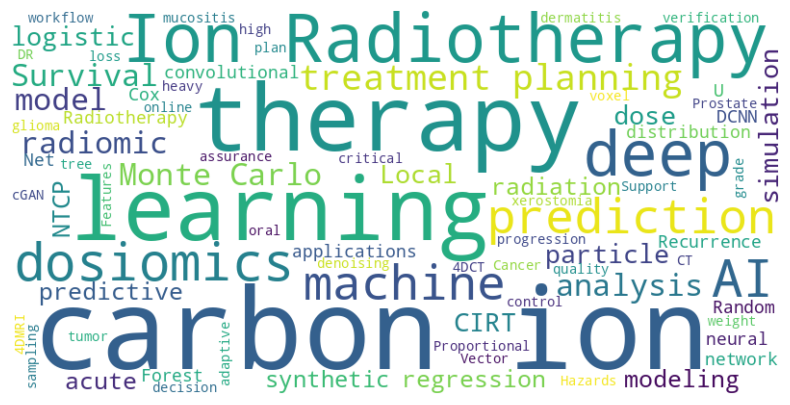

In [138]:
# Sample text
# text = """
# Python is amazing. Seaborn makes beautiful plots.
# Word clouds are a fun way to visualize text data.
# Machine learning, deep learning, AI, data science.
# """

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', random_state=0).generate(gt)

# Plot
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis
# plt.title('Word Cloud Example with Seaborn Style', fontsize=20)
plt.show()


In [ ]:
# LDA (Latent Dirichlet Allocation) in Python to find topics (clusters) from text. is a topic modeling technique.; It tries to find hidden topics in a # large amount of text.# Each document is a mixture of topics; each topic is a mixture of words. It's unsupervised — you don’t label anything manually.

import nltk
from nltk.corpus import stopwords
from gensim import corpora, models
import gensim
import pprint

# Download NLTK stopwords (if not already done)
nltk.download('stopwords')

# Sample documents
documents = [
    "I love deep learning and neural networks",
    "Data science is my passion, I love statistics",
    "Python programming for machine learning and AI",
    "R is great for statistics and data analysis",
    "Artificial intelligence and machine learning are the future",
    "Statistics is key for data science"
]

# Preprocessing
stop_words = stopwords.words('english')

texts = [
    [word.lower() for word in doc.split() if word.lower() not in stop_words]
    for doc in documents
]

# Create dictionary and corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# LDA model
lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=2,      # number of topics you want
    random_state=42,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

# Show topics
pprint.pprint(lda_model.print_topics())